# Simulated DCA Demo

In [1]:
from hyppo.tools import SIMULATIONS
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pickle

import dist_cov as dc

In [2]:
np.random.seed(4)

# 1D Simulated Linear Independence Data
## Plot Dataset

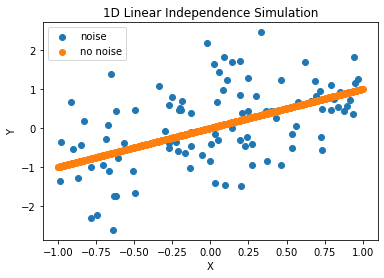

In [3]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(100, 1, noise=True)
lin_x, lin_y = lin_sim(1000, 1)
plt.scatter(lin_x_n, lin_y_n)
plt.scatter(lin_x, lin_y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("1D Linear Independence Simulation")
plt.legend(["noise", "no noise"]);

## Initialize Data

In [4]:
X, Y = lin_sim(10, 1, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1], 1)
u_normalized_norm = LA.norm(dc.normalize_u(u))
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_normalized_norm}")
R_X_u = dc.re_centered_dist_u(u, X)

X shape: (10, 1)
Y shape: (10, 1)
u: [[0.01399029]]
u norm: 1.0


## Test Function Dimension Alignment

In [5]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [0.10216473]
v^2: 0.10216472924060425


## Optimize $u$

In [6]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd_stochastic(u, X, R_Y, 1e-1, 1e-7)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.001429314067626644
u opt: [[1.]]
v^2_u_opt: 0.10216472924060425


## Plot Gradient Ascent

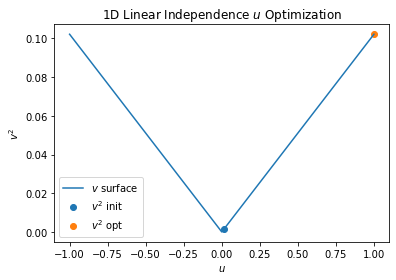

In [7]:
u_plt = np.expand_dims(np.linspace(-1, 1, 11), 1)
v_u_plt = np.zeros_like(u_plt)
for i in range(u_plt.shape[0]):
    R_X_u_i = dc.re_centered_dist_u(u_plt[i], X)
    v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
    v_u_plt[i] = v_u_i
plt.plot(u_plt, v_u_plt)
plt.scatter([u], [v_u])
plt.scatter([u_opt], [v_opt])
plt.xlabel(r"$u$")
plt.ylabel(r"$v^2$")
plt.title(r"1D Linear Independence $u$ Optimization")
plt.legend([r'$v$ surface', r'$v^2$ init', r'$v^2$ opt']);

# 2D Simulated Linear Independence Data
## Plot Dataset

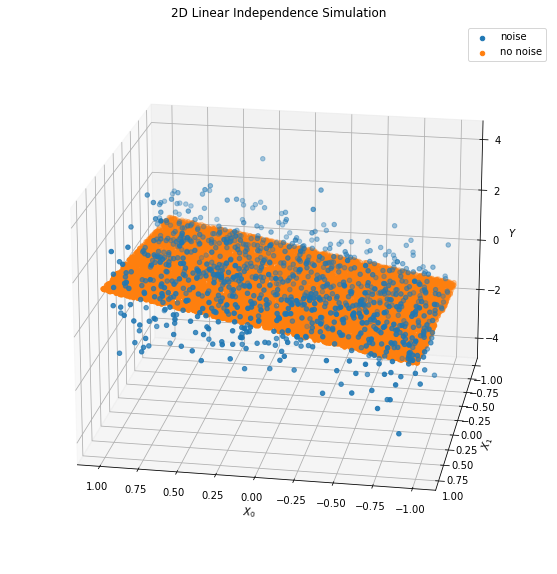

In [8]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(1000, 2, noise=True)
lin_x, lin_y = lin_sim(10000, 2)

lin_x_1_n = lin_x_n[:, 0]
lin_x_2_n = lin_x_n[:, 1]
lin_x_1 = lin_x[:, 0]
lin_x_2 = lin_x[:, 1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(lin_x_1_n, lin_x_2_n, lin_y_n)
ax.scatter(lin_x_1, lin_x_2, lin_y)
ax.set_xlabel(r"$X_0$")
ax.set_ylabel(r"$X_1$")
ax.set_zlabel(r"$Y$")
plt.title("2D Linear Independence Simulation")
plt.legend(["noise", "no noise"])
ax.view_init(elev=20, azim=100);

## Initialize Data

In [9]:
X, Y = lin_sim(10, 2, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.normalize_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X)

X shape: (10, 2)
Y shape: (10, 1)
u: [0.2867837  0.95799536]
u norm: 1.0


## Test Function Dimension Alignment

In [10]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [0.05875093 0.13977297]
v^2: 0.1422482374453341


## Optimize $u$

In [11]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd_stochastic(u, X, R_Y, 1e-2, 1e-14)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.15075066320606503
u opt: [0.37811091 0.9257603 ]
v^2_u_opt: 0.15161063231866945


## Plot Gradient Ascent

In [12]:
surf_res = 1e-1
X_surf = np.arange(-1, 1, surf_res)
Y_surf = np.arange(-1, 1, surf_res)
X_surf, Y_surf = np.meshgrid(X_surf, Y_surf)
v_u_plt = np.zeros_like(X_surf)
for i in range(X_surf.shape[0]):
    for j in range(X_surf.shape[1]):
        R_X_u_i = dc.re_centered_dist_u(np.array([X_surf[i, j], Y_surf[i, j]]), X)
        v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
        v_u_plt[i, j] = v_u_i

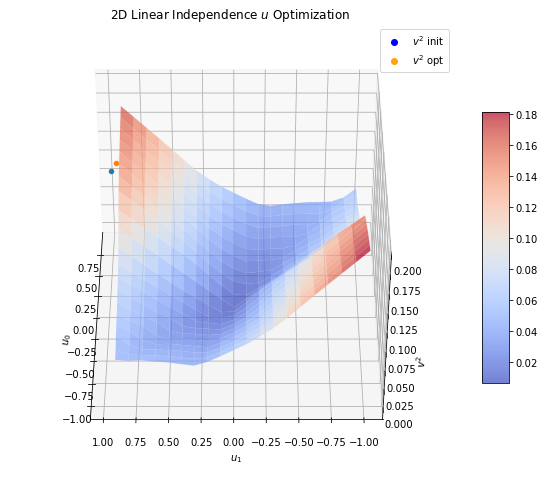

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(X_surf, Y_surf, v_u_plt, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=.7)
ax.scatter([u[0]], [u[1]], [v_u])
ax.scatter([u_opt[0]], [u_opt[1]], [v_opt])
ax.set_xlabel(r"$u_0$")
ax.set_ylabel(r"$u_1$")
ax.set_zlabel(r"$v^2$")
ax.set_title(r"2D Linear Independence $u$ Optimization")
init_proxy = Line2D([0], [0], linestyle="none", c='blue', marker='o')
opt_proxy = Line2D([0], [0], linestyle="none", c='orange', marker='o')
ax.legend([init_proxy, opt_proxy], [r"$v^2$ init", r"$v^2$ opt"], numpoints=1)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(elev=40, azim=180);

# nD Simulated Linear Independence Data
## Initialize Data

In [14]:
lin_sim = SIMULATIONS["linear"]
X, Y = lin_sim(100, 10, noise=True)
D_X = dc.dist_mat(X)
D_Y = dc.dist_mat(Y)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1])
u = dc.normalize_u(u)
u_norm = LA.norm(u)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X)

X shape: (100, 10)
Y shape: (100, 1)
u: [0.38977862 0.52540543 0.27818561 0.34023135 0.40612298 0.08212936
 0.38901221 0.19202377 0.11058984 0.08223332]
u norm: 0.9999999999999999


## Test Function Dimension Alignment

In [15]:
du = dc.dist_cov_sq_grad(u, X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [ 0.02521931  0.00235031  0.00798072 -0.01185628  0.04319527 -0.00418842
  0.00089619  0.01059892  0.03252896 -0.02696957]
v^2: 0.039824902183455115


## Optimize $u$

In [16]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt, v_opt = dc.optim_u_gd_stochastic(u, X, R_Y, 1e-1, 1e-10)
print(f"u opt: {u_opt}")
print(f"v^2_u_opt: {v_opt}")

v^2_u: 0.030213101657117027
u opt: [0.39000971 0.52284823 0.27974566 0.33888735 0.40454575 0.08006158
 0.39309545 0.19455819 0.11047144 0.08229158]
v^2_u_opt: 0.030200214530230966


## DCA

In [17]:
print(f"X shape: {X.shape}")
print(f"X:\n{X[:5]}")
U, v_dca = dc.dca(X, Y, K=3, lr=1e-1, epsilon=1e-10)
print(f"U shape: {U.shape}")
print(f"U:\n{U}")
print(f"v shape: {v_dca.shape}")
print(f"v: {v_dca}")
X_reduced = X @ U
print(f"X_reduced shape: {X_reduced.shape}")
print(f"X_reduced:\n{X_reduced[:5]}")

X shape: (100, 10)
X:
[[ 0.84367487  0.59055967 -0.90330268  0.42520446 -0.93288145  0.25894444
  -0.02408268  0.19741321 -0.21249909  0.7962459 ]
 [ 0.13209223  0.8794208   0.99416749 -0.3874725   0.33111758 -0.5659056
  -0.63490904 -0.88793092  0.14382386 -0.89267131]
 [-0.2998885   0.03789094 -0.84093787 -0.37063526  0.03754482  0.14315919
  -0.72971109 -0.09711561  0.42887034 -0.36616142]
 [ 0.92497451  0.93491036 -0.2520113  -0.70259691  0.34758926 -0.67581131
  -0.13421364 -0.79955077  0.71647205 -0.69089795]
 [ 0.12123103 -0.23498571 -0.75262602  0.56120889 -0.00354126  0.14461479
  -0.3880353  -0.69730286 -0.94424781  0.33666431]]
U shape: (10, 3)
U:
[[0.06997508 0.09872578 0.30190875]
 [0.16266078 0.1829759  0.00497949]
 [0.44497727 0.01052074 0.02955271]
 [0.44130212 0.32336879 0.21070864]
 [0.20806817 0.24686676 0.62801792]
 [0.2809335  0.31375955 0.38143649]
 [0.36246957 0.1552551  0.46284964]
 [0.35048222 0.56805792 0.23502728]
 [0.13611668 0.51446173 0.02737536]
 [0.42535

# Projection

In [18]:
k_pt = 1
X_pt = np.array([5, 1])
X_pt = X_pt / LA.norm(X_pt)
U_pt = np.array([1, 2])
U_pt = U_pt / LA.norm(U_pt)
U_pt = np.expand_dims(U_pt, 0)
q_pt = LA.qr(U_pt[:, :k_pt])
X_proj_pt = dc.proj_U(X_pt, U_pt, k_pt)
print(q_pt)

(array([[1.]]), array([[0.4472136]]))


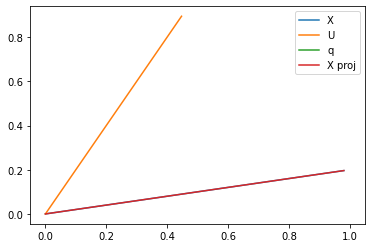

In [19]:
x_range_pt = np.linspace(0, 1, 11)
plt.plot(X_pt[0] * x_range_pt, X_pt[1] * x_range_pt)
plt.plot(U_pt[:, 0] * x_range_pt, U_pt[:, 1] * x_range_pt)
plt.plot(q_pt[0] * x_range_pt, q_pt[1] * x_range_pt)
plt.plot(X_proj_pt[0] * x_range_pt, X_proj_pt[1] * x_range_pt)
plt.legend(["X", "U", "q", "X proj"]);

# Replicate Figure 2 from Cowley

In [20]:
def unit_vec(v):
    return v / LA.norm(v)

def vec_angle(v0, v1):
    """
    Radians
    """
    u0 = unit_vec(v0)
    u1 = unit_vec(v1)
    return np.arccos(np.clip(np.dot(u0, u1), -1., 1.))

def beta_angle(beta_hat, beta):
    """
    Mean of all beta_i vectors (P x 1)
    """
    angle = 0
    b = beta_hat.shape[1]
    for i in range(b):
        v0 = beta_hat[:, i]
        v1 = beta[:, i]
        angle += vec_angle(v0, v1)
    return angle / (N * b)

def generate_data(N, P, b, f):
    """
    N: number of samples
    P: number of features
    b: number of dimensions identified from dimensionality reduction
    f: degree of nonlinearity
    returns
        X: (P x N): (feature x sample)
        beta: (P x b), beta_i: (P x 1)
        Y: (b x N)
    """
    X = np.random.normal(size=(P, N))
    beta = np.random.normal(size=(P, b))
    beta, _ = LA.qr(beta)
    alpha = 8 * np.sqrt(50) * LA.norm(X, ord=np.inf) # normalization constant
    Y = np.zeros((b, N))
    for i in range(N):
        Y[:, i] = np.sin(2 * np.pi / alpha * f * beta.T @ X[:, i]) # (b x P) @ (P x 1) = (b x 1)
    return X, beta, Y

In [21]:
N = 100 # sample
P = 5 # feature
b = 2 # number of dimensions identified from dimensionality reduction
trial_ct = 10
f_range = [1] + [i for i in range(10, 130, 10)] # degree of nonlinearity
beta_angles = np.zeros((trial_ct, len(f_range)))
for i in range(trial_ct):
    print(f"trial: {i}")
    for j, f in enumerate(f_range):
        X, beta, Y = generate_data(N, P, b, f)
        beta_hat, v_hat = dc.dca(X.T, Y.T, K=b, lr=1e-1, epsilon=1e-10)
        angle = beta_angle(beta_hat, beta)
        print(f"f: {f}")
        print(f"beta angle: {np.rad2deg(angle)} deg")
        beta_angles[i, j] = angle
with open("dca_betas.pickle", 'wb') as wf:
    pickle.dump(beta_angles, wf)

trial: 0
f: 1
beta angle: 1.1080436928060433 deg
f: 10
beta angle: 1.158111933262706 deg
f: 20
beta angle: 1.2197102079340636 deg
f: 30
beta angle: 0.7133416693419323 deg
f: 40
beta angle: 1.1056693299277558 deg
f: 50
beta angle: 1.0551134311619663 deg
f: 60
beta angle: 0.6617346062610402 deg
f: 70
beta angle: 0.9488393113407569 deg
f: 80
beta angle: 1.106729567691805 deg
f: 90
beta angle: 0.8380411618290128 deg
f: 100
beta angle: 0.9328745378273531 deg
f: 110
beta angle: 0.8550004175299473 deg
f: 120
beta angle: 1.1650339687093914 deg
trial: 1
f: 1
beta angle: 1.2550614005764011 deg
f: 10
beta angle: 1.1297009720524658 deg
f: 20
beta angle: 1.1746290492493947 deg
f: 30
beta angle: 0.9827887848885221 deg
f: 40
beta angle: 0.6719551280333573 deg
f: 50
beta angle: 1.1672775578060823 deg
f: 60
beta angle: 0.5178994060600102 deg
f: 70
beta angle: 0.8725303806971942 deg
f: 80
beta angle: 1.2916017314841617 deg
f: 90
beta angle: 0.623324142281445 deg
f: 100
beta angle: 1.1474614145197906 deg

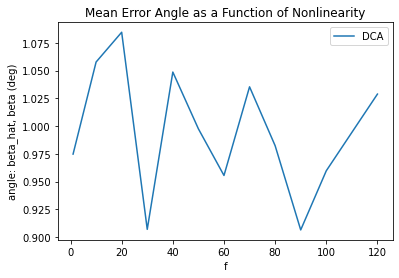

In [22]:
with open("dca_betas.pickle", 'rb') as rf:
    beta_angles = pickle.load(rf)
plt.plot(f_range, np.mean(np.rad2deg(beta_angles), axis=0))
plt.title("Mean Error Angle as a Function of Nonlinearity")
plt.xlabel("f")
plt.ylabel("angle: beta_hat, beta (deg)")
plt.legend(["DCA"]);